In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [2]:
df = pd.read_csv('data/data/daily_min_temp.csv', index_col = 'Date', parse_dates= ['Date'])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


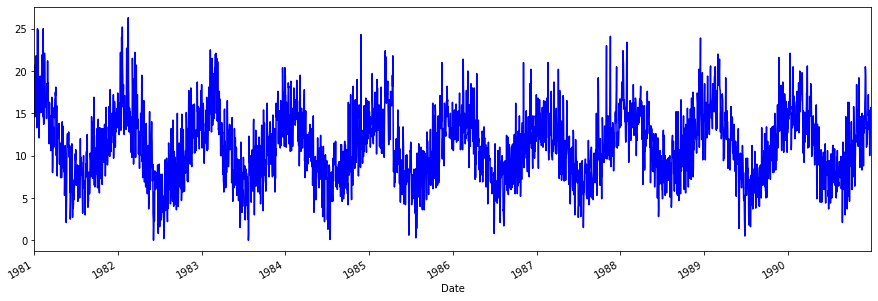

In [3]:
df.Temp.plot(figsize = (15, 5), color = 'b')

# Dataset Splitting

In [4]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle = False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset and Dataloader

In [5]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import TensorDataset, DataLoader

In [6]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Architecture & Configuration

In [7]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout = dropout, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc (x)
        return x, hidden

In [8]:
config = set_config({
    'input_size': train_set.n_feature,
    'seq_len': train_set.n_seq,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0,
    'output_size': 1,    
})

# Training Preparation

In [18]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/gru")

# Training

In [19]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 127.0135 | Test_cost  = 118.4685 | 




Epoch     2
Train_cost  = 101.3977 | Test_cost  = 93.8544 | 




Epoch     3
Train_cost  = 79.8153 | Test_cost  = 75.4028 | 




Epoch     4
Train_cost  = 64.5696 | Test_cost  = 63.0458 | 




Epoch     5
Train_cost  = 54.3594 | Test_cost  = 54.3373 | 




Epoch     6
Train_cost  = 46.9966 | Test_cost  = 47.6480 | 




Epoch     7
Train_cost  = 41.2501 | Test_cost  = 42.2270 | 




Epoch     8
Train_cost  = 36.5758 | Test_cost  = 37.7237 | 




Epoch     9
Train_cost  = 32.7025 | Test_cost  = 33.9468 | 




Epoch    10
Train_cost  = 29.4801 | Test_cost  = 30.7808 | 




Epoch    11
Train_cost  = 26.8082 | Test_cost  = 28.1380 | 




Epoch    12
Train_cost  = 24.6066 | Test_cost  = 25.9447 | 




Epoch    13
Train_cost  = 22.8068 | Test_cost  = 24.1366 | 




Epoch    14
Train_cost  = 21.3485 | Test_cost  = 22.6568 | 




Epoch    15
Train_cost  = 20.1782 | Test_cost  = 21.4547 | 




Epoch    16
Train_cost  = 19.2483 | Test_cost  = 20.4852 | 




Epoch    17
Train_cost  = 18.5169 | Test_cost  = 19.7087 | 




Epoch    18
Train_cost  = 17.9475 | Test_cost  = 19.0907 | 




Epoch    19
Train_cost  = 17.5085 | Test_cost  = 18.6016 | 




Epoch    20
Train_cost  = 17.1733 | Test_cost  = 18.2164 | 


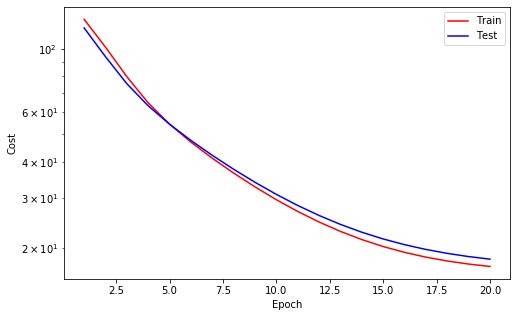



Epoch    21
Train_cost  = 16.9196 | Test_cost  = 17.9142 | 




Epoch    22
Train_cost  = 16.7291 | Test_cost  = 17.6776 | 




Epoch    23
Train_cost  = 16.5870 | Test_cost  = 17.4928 | 




Epoch    24
Train_cost  = 16.4816 | Test_cost  = 17.3484 | 




Epoch    25
Train_cost  = 16.4037 | Test_cost  = 17.2355 | 




Epoch    26
Train_cost  = 16.3460 | Test_cost  = 17.1471 | 




Epoch    27
Train_cost  = 16.3033 | Test_cost  = 17.0776 | 




Epoch    28
Train_cost  = 16.2713 | Test_cost  = 17.0227 | 




Epoch    29
Train_cost  = 16.2470 | Test_cost  = 16.9791 | 




Epoch    30
Train_cost  = 16.2283 | Test_cost  = 16.9442 | 




Epoch    31
Train_cost  = 16.2134 | Test_cost  = 16.9161 | 




Epoch    32
Train_cost  = 16.2012 | Test_cost  = 16.8933 | 




Epoch    33
Train_cost  = 16.1907 | Test_cost  = 16.8744 | 




Epoch    34
Train_cost  = 16.1815 | Test_cost  = 16.8585 | 




Epoch    35
Train_cost  = 16.1728 | Test_cost  = 16.8449 | 




Epoch    36
Train_cost  = 16.1644 | Test_cost  = 16.8328 | 




Epoch    37
Train_cost  = 16.1559 | Test_cost  = 16.8217 | 




Epoch    38
Train_cost  = 16.1469 | Test_cost  = 16.8110 | 




Epoch    39
Train_cost  = 16.1370 | Test_cost  = 16.8001 | 




Epoch    40
Train_cost  = 16.1258 | Test_cost  = 16.7883 | 


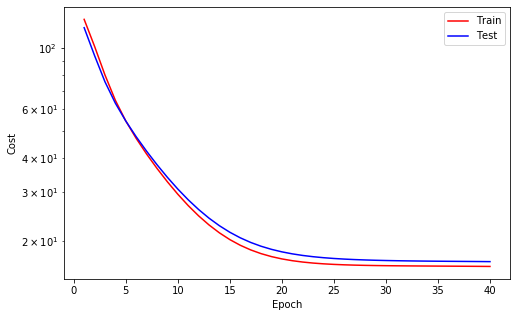



Epoch    41
Train_cost  = 16.1125 | Test_cost  = 16.7748 | 




Epoch    42
Train_cost  = 16.0964 | Test_cost  = 16.7585 | 




Epoch    43
Train_cost  = 16.0760 | Test_cost  = 16.7375 | 




Epoch    44
Train_cost  = 16.0488 | Test_cost  = 16.7085 | 




Epoch    45
Train_cost  = 16.0102 | Test_cost  = 16.6649 | 




Epoch    46
Train_cost  = 15.9507 | Test_cost  = 16.5914 | 




Epoch    47
Train_cost  = 15.8446 | Test_cost  = 16.4371 | 




Epoch    48
Train_cost  = 15.5990 | Test_cost  = 16.0460 | 




Epoch    49
Train_cost  = 15.0380 | Test_cost  = 15.3983 | 




Epoch    50
Train_cost  = 14.1930 | Test_cost  = 14.3414 | 




Epoch    51
Train_cost  = 13.0520 | Test_cost  = 13.2460 | 




Epoch    52
Train_cost  = 12.2885 | Test_cost  = 12.5710 | 




Epoch    53
Train_cost  = 11.7422 | Test_cost  = 11.9162 | 




Epoch    54
Train_cost  = 11.1957 | Test_cost  = 11.2720 | 




Epoch    55
Train_cost  = 10.6864 | Test_cost  = 10.6665 | 




Epoch    56
Train_cost  = 10.2203 | Test_cost  = 10.1153 | 




Epoch    57
Train_cost  = 9.8090 | Test_cost  = 9.6305 | 




Epoch    58
Train_cost  = 9.4526 | Test_cost  = 9.2143 | 




Epoch    59
Train_cost  = 9.1393 | Test_cost  = 8.8524 | 




Epoch    60
Train_cost  = 8.8629 | Test_cost  = 8.5283 | 


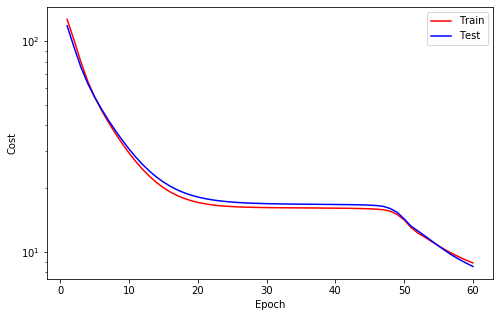



Epoch    61
Train_cost  = 8.6169 | Test_cost  = 8.2394 | 




Epoch    62
Train_cost  = 8.3999 | Test_cost  = 7.9862 | 




Epoch    63
Train_cost  = 8.2135 | Test_cost  = 7.7630 | 




Epoch    64
Train_cost  = 8.0535 | Test_cost  = 7.5660 | 




Epoch    65
Train_cost  = 7.9133 | Test_cost  = 7.3936 | 




Epoch    66
Train_cost  = 7.7889 | Test_cost  = 7.2427 | 




Epoch    67
Train_cost  = 7.6783 | Test_cost  = 7.1090 | 




Epoch    68
Train_cost  = 7.5795 | Test_cost  = 6.9894 | 




Epoch    69
Train_cost  = 7.4903 | Test_cost  = 6.8813 | 




Epoch    70
Train_cost  = 7.4091 | Test_cost  = 6.7828 | 




Epoch    71
Train_cost  = 7.3350 | Test_cost  = 6.6928 | 




Epoch    72
Train_cost  = 7.2672 | Test_cost  = 6.6102 | 




Epoch    73
Train_cost  = 7.2050 | Test_cost  = 6.5343 | 




Epoch    74
Train_cost  = 7.1480 | Test_cost  = 6.4642 | 




Epoch    75
Train_cost  = 7.0956 | Test_cost  = 6.3993 | 




Epoch    76
Train_cost  = 7.0474 | Test_cost  = 6.3388 | 




Epoch    77
Train_cost  = 7.0027 | Test_cost  = 6.2824 | 




Epoch    78
Train_cost  = 6.9613 | Test_cost  = 6.2295 | 




Epoch    79
Train_cost  = 6.9227 | Test_cost  = 6.1798 | 




Epoch    80
Train_cost  = 6.8867 | Test_cost  = 6.1330 | 


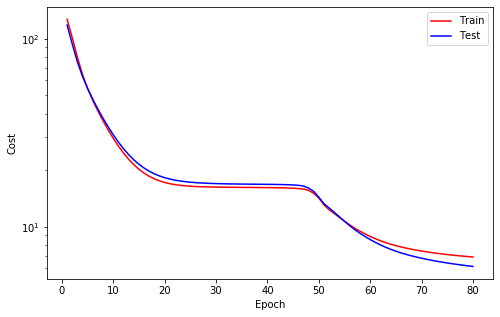



Epoch    81
Train_cost  = 6.8531 | Test_cost  = 6.0887 | 




Epoch    82
Train_cost  = 6.8215 | Test_cost  = 6.0469 | 




Epoch    83
Train_cost  = 6.7917 | Test_cost  = 6.0074 | 




Epoch    84
Train_cost  = 6.7637 | Test_cost  = 5.9702 | 




Epoch    85
Train_cost  = 6.7372 | Test_cost  = 5.9349 | 




Epoch    86
Train_cost  = 6.7120 | Test_cost  = 5.9016 | 




Epoch    87
Train_cost  = 6.6881 | Test_cost  = 5.8699 | 




Epoch    88
Train_cost  = 6.6653 | Test_cost  = 5.8396 | 




Epoch    89
Train_cost  = 6.6436 | Test_cost  = 5.8107 | 




Epoch    90
Train_cost  = 6.6229 | Test_cost  = 5.7830 | 




Epoch    91
Train_cost  = 6.6030 | Test_cost  = 5.7563 | 




Epoch    92
Train_cost  = 6.5840 | Test_cost  = 5.7307 | 




Epoch    93
Train_cost  = 6.5658 | Test_cost  = 5.7059 | 




Epoch    94
Train_cost  = 6.5484 | Test_cost  = 5.6821 | 




Epoch    95
Train_cost  = 6.5316 | Test_cost  = 5.6591 | 




Epoch    96
Train_cost  = 6.5154 | Test_cost  = 5.6369 | 




Epoch    97
Train_cost  = 6.4999 | Test_cost  = 5.6154 | 




Epoch    98
Train_cost  = 6.4850 | Test_cost  = 5.5948 | 




Epoch    99
Train_cost  = 6.4707 | Test_cost  = 5.5749 | 




Epoch   100
Train_cost  = 6.4570 | Test_cost  = 5.5557 | 


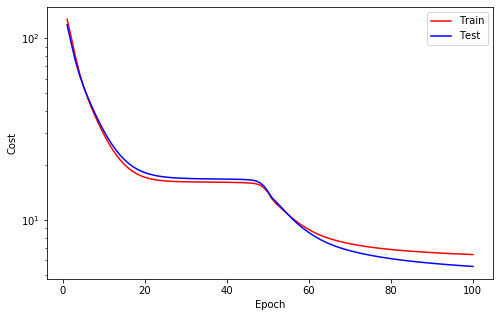



Epoch   101
Train_cost  = 6.4439 | Test_cost  = 5.5371 | 




Epoch   102
Train_cost  = 6.4312 | Test_cost  = 5.5192 | 




Epoch   103
Train_cost  = 6.4190 | Test_cost  = 5.5018 | 




Epoch   104
Train_cost  = 6.4073 | Test_cost  = 5.4851 | 




Epoch   105
Train_cost  = 6.3960 | Test_cost  = 5.4689 | 




Epoch   106
Train_cost  = 6.3851 | Test_cost  = 5.4532 | 




Epoch   107
Train_cost  = 6.3746 | Test_cost  = 5.4382 | 




Epoch   108
Train_cost  = 6.3645 | Test_cost  = 5.4236 | 




Epoch   109
Train_cost  = 6.3548 | Test_cost  = 5.4094 | 




Epoch   110
Train_cost  = 6.3454 | Test_cost  = 5.3957 | 




Epoch   111
Train_cost  = 6.3363 | Test_cost  = 5.3824 | 




Epoch   112
Train_cost  = 6.3275 | Test_cost  = 5.3694 | 




Epoch   113
Train_cost  = 6.3191 | Test_cost  = 5.3568 | 




Epoch   114
Train_cost  = 6.3109 | Test_cost  = 5.3447 | 




Epoch   115
Train_cost  = 6.3029 | Test_cost  = 5.3329 | 




Epoch   116
Train_cost  = 6.2953 | Test_cost  = 5.3216 | 




Epoch   117
Train_cost  = 6.2878 | Test_cost  = 5.3106 | 




Epoch   118
Train_cost  = 6.2806 | Test_cost  = 5.2999 | 




Epoch   119
Train_cost  = 6.2736 | Test_cost  = 5.2897 | 




Epoch   120
Train_cost  = 6.2668 | Test_cost  = 5.2797 | 


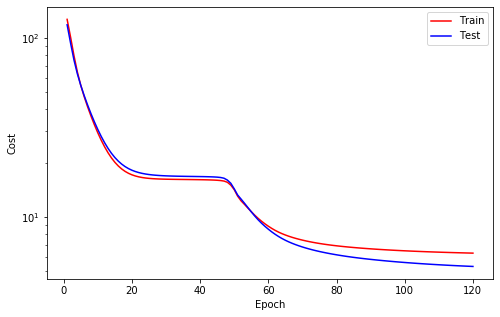



Epoch   121
Train_cost  = 6.2601 | Test_cost  = 5.2701 | 




Epoch   122
Train_cost  = 6.2536 | Test_cost  = 5.2608 | 




Epoch   123
Train_cost  = 6.2473 | Test_cost  = 5.2517 | 




Epoch   124
Train_cost  = 6.2412 | Test_cost  = 5.2429 | 




Epoch   125
Train_cost  = 6.2352 | Test_cost  = 5.2344 | 




Epoch   126
Train_cost  = 6.2293 | Test_cost  = 5.2261 | 




Epoch   127
Train_cost  = 6.2236 | Test_cost  = 5.2181 | 




Epoch   128
Train_cost  = 6.2180 | Test_cost  = 5.2102 | 




Epoch   129
Train_cost  = 6.2125 | Test_cost  = 5.2026 | 




Epoch   130
Train_cost  = 6.2071 | Test_cost  = 5.1952 | 




Epoch   131
Train_cost  = 6.2018 | Test_cost  = 5.1880 | 




Epoch   132
Train_cost  = 6.1967 | Test_cost  = 5.1810 | 




Epoch   133
Train_cost  = 6.1916 | Test_cost  = 5.1741 | 




Epoch   134
Train_cost  = 6.1866 | Test_cost  = 5.1675 | 




Epoch   135
Train_cost  = 6.1818 | Test_cost  = 5.1610 | 




Epoch   136
Train_cost  = 6.1770 | Test_cost  = 5.1547 | 




Epoch   137
Train_cost  = 6.1723 | Test_cost  = 5.1486 | 




Epoch   138
Train_cost  = 6.1677 | Test_cost  = 5.1426 | 




Epoch   139
Train_cost  = 6.1632 | Test_cost  = 5.1367 | 




Epoch   140
Train_cost  = 6.1588 | Test_cost  = 5.1311 | 


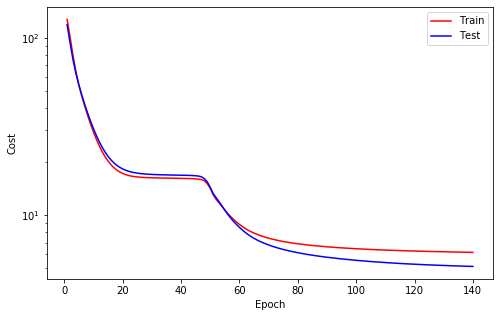



Epoch   141
Train_cost  = 6.1544 | Test_cost  = 5.1255 | 




Epoch   142
Train_cost  = 6.1501 | Test_cost  = 5.1201 | 




Epoch   143
Train_cost  = 6.1458 | Test_cost  = 5.1149 | 




Epoch   144
Train_cost  = 6.1417 | Test_cost  = 5.1098 | 




Epoch   145
Train_cost  = 6.1376 | Test_cost  = 5.1048 | 




Epoch   146
Train_cost  = 6.1335 | Test_cost  = 5.0999 | 




Epoch   147
Train_cost  = 6.1295 | Test_cost  = 5.0951 | 




Epoch   148
Train_cost  = 6.1256 | Test_cost  = 5.0905 | 




Epoch   149
Train_cost  = 6.1217 | Test_cost  = 5.0860 | 




Epoch   150
Train_cost  = 6.1178 | Test_cost  = 5.0816 | 




Epoch   151
Train_cost  = 6.1141 | Test_cost  = 5.0774 | 




Epoch   152
Train_cost  = 6.1103 | Test_cost  = 5.0732 | 




Epoch   153
Train_cost  = 6.1066 | Test_cost  = 5.0692 | 




Epoch   154
Train_cost  = 6.1029 | Test_cost  = 5.0653 | 




Epoch   155
Train_cost  = 6.0993 | Test_cost  = 5.0615 | 




Epoch   156
Train_cost  = 6.0957 | Test_cost  = 5.0579 | 




Epoch   157
Train_cost  = 6.0922 | Test_cost  = 5.0544 | 




Epoch   158
Train_cost  = 6.0887 | Test_cost  = 5.0510 | 




Epoch   159
Train_cost  = 6.0852 | Test_cost  = 5.0477 | 




Epoch   160
Train_cost  = 6.0817 | Test_cost  = 5.0445 | 


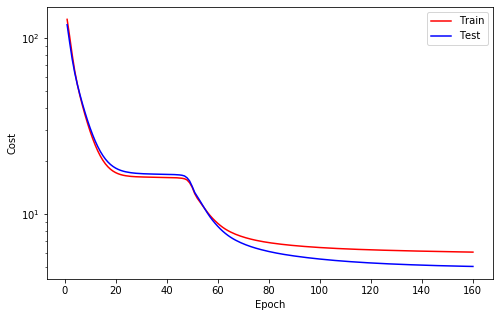



Epoch   161
Train_cost  = 6.0783 | Test_cost  = 5.0415 | 




Epoch   162
Train_cost  = 6.0750 | Test_cost  = 5.0385 | 




Epoch   163
Train_cost  = 6.0716 | Test_cost  = 5.0357 | 




Epoch   164
Train_cost  = 6.0683 | Test_cost  = 5.0330 | 




Epoch   165
Train_cost  = 6.0650 | Test_cost  = 5.0305 | 




Epoch   166
Train_cost  = 6.0618 | Test_cost  = 5.0280 | 




Epoch   167
Train_cost  = 6.0585 | Test_cost  = 5.0257 | 




Epoch   168
Train_cost  = 6.0553 | Test_cost  = 5.0235 | 




Epoch   169
Train_cost  = 6.0522 | Test_cost  = 5.0214 | 




Epoch   170
Train_cost  = 6.0490 | Test_cost  = 5.0195 | 




Epoch   171
Train_cost  = 6.0459 | Test_cost  = 5.0177 | 




Epoch   172
Train_cost  = 6.0428 | Test_cost  = 5.0160 | 




Epoch   173
Train_cost  = 6.0397 | Test_cost  = 5.0144 | 




Epoch   174
Train_cost  = 6.0367 | Test_cost  = 5.0129 | 




Epoch   175
Train_cost  = 6.0336 | Test_cost  = 5.0115 | 




Epoch   176
Train_cost  = 6.0306 | Test_cost  = 5.0103 | 




Epoch   177
Train_cost  = 6.0276 | Test_cost  = 5.0091 | 




Epoch   178
Train_cost  = 6.0247 | Test_cost  = 5.0079 | 




Epoch   179
Train_cost  = 6.0217 | Test_cost  = 5.0069 | 




Epoch   180
Train_cost  = 6.0188 | Test_cost  = 5.0059 | 


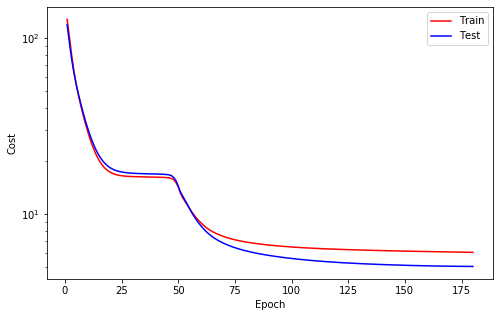



Epoch   181
Train_cost  = 6.0159 | Test_cost  = 5.0049 | 




Epoch   182
Train_cost  = 6.0131 | Test_cost  = 5.0041 | 




Epoch   183
Train_cost  = 6.0102 | Test_cost  = 5.0032 | 




Epoch   184
Train_cost  = 6.0074 | Test_cost  = 5.0024 | 




Epoch   185
Train_cost  = 6.0046 | Test_cost  = 5.0017 | 




Epoch   186
Train_cost  = 6.0018 | Test_cost  = 5.0010 | 




Epoch   187
Train_cost  = 5.9990 | Test_cost  = 5.0003 | 




Epoch   188
Train_cost  = 5.9962 | Test_cost  = 4.9997 | 




Epoch   189
Train_cost  = 5.9934 | Test_cost  = 4.9992 | 




Epoch   190
Train_cost  = 5.9906 | Test_cost  = 4.9987 | 




Epoch   191
Train_cost  = 5.9879 | Test_cost  = 4.9982 | 




Epoch   192
Train_cost  = 5.9851 | Test_cost  = 4.9977 | 




Epoch   193
Train_cost  = 5.9824 | Test_cost  = 4.9973 | 




Epoch   194
Train_cost  = 5.9796 | Test_cost  = 4.9969 | 




Epoch   195
Train_cost  = 5.9769 | Test_cost  = 4.9966 | 




Epoch   196
Train_cost  = 5.9742 | Test_cost  = 4.9963 | 




Epoch   197
Train_cost  = 5.9715 | Test_cost  = 4.9960 | 




Epoch   198
Train_cost  = 5.9688 | Test_cost  = 4.9957 | 




Epoch   199
Train_cost  = 5.9661 | Test_cost  = 4.9955 | 




Epoch   200
Train_cost  = 5.9634 | Test_cost  = 4.9954 | 


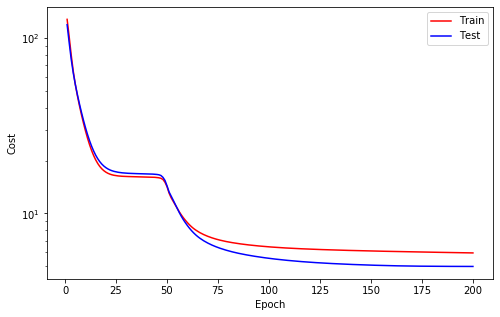



Epoch   201
Train_cost  = 5.9607 | Test_cost  = 4.9952 | 




Epoch   202
Train_cost  = 5.9581 | Test_cost  = 4.9951 | 




Epoch   203
Train_cost  = 5.9554 | Test_cost  = 4.9950 | 




Epoch   204
Train_cost  = 5.9528 | Test_cost  = 4.9950 | 




Epoch   205
Train_cost  = 5.9501 | Test_cost  = 4.9950 | 
==> EarlyStop patience =  1 | Best test_cost: 4.9950




Epoch   206
Train_cost  = 5.9474 | Test_cost  = 4.9950 | 
==> EarlyStop patience =  2 | Best test_cost: 4.9950




Epoch   207
Train_cost  = 5.9448 | Test_cost  = 4.9951 | 
==> EarlyStop patience =  3 | Best test_cost: 4.9950




Epoch   208
Train_cost  = 5.9421 | Test_cost  = 4.9952 | 
==> EarlyStop patience =  4 | Best test_cost: 4.9950




Epoch   209
Train_cost  = 5.9395 | Test_cost  = 4.9954 | 
==> EarlyStop patience =  5 | Best test_cost: 4.9950
==> Execute Early Stopping at epoch: 209 | Best test_cost: 4.9950
==> Best model is saved at model/gru


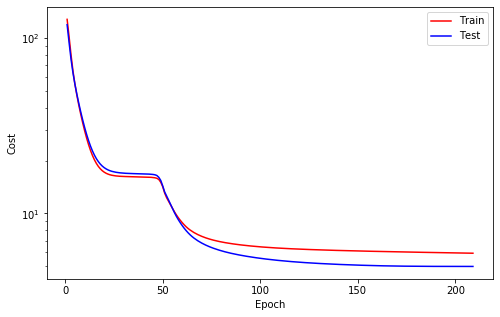

In [20]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [21]:
from utils import data4pred, pred4pred

In [22]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Train')

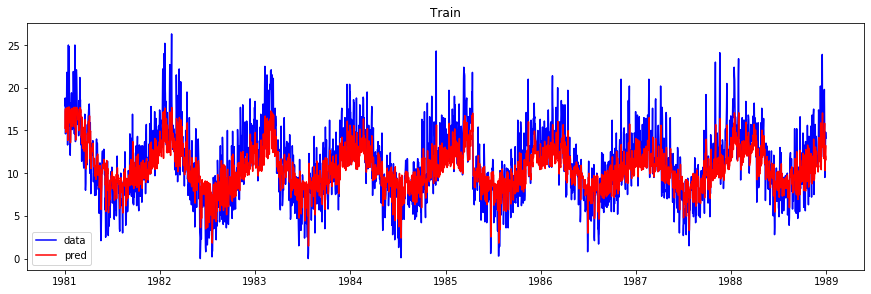

In [23]:
plt.figure(figsize =(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')


Text(0.5, 1.0, 'Test')

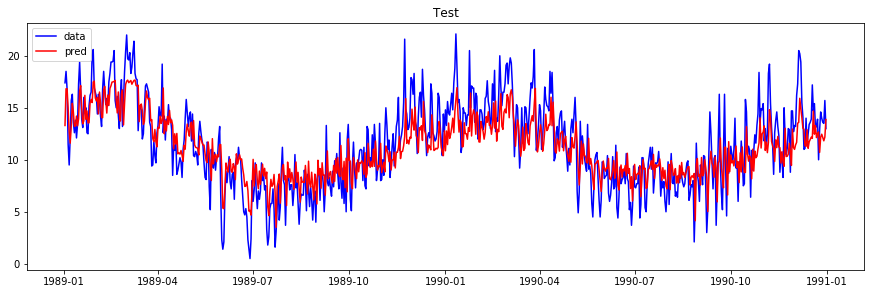

In [24]:
plt.figure(figsize =(15, 10))
plt.subplot(211)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'test')

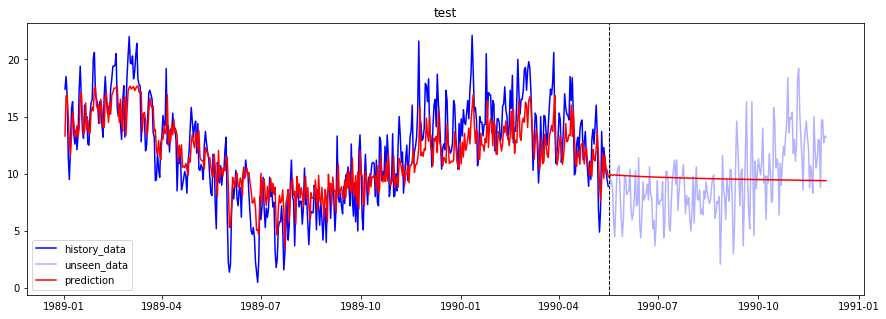

In [25]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('test')